# Generating a Dataset with Descriptors and Morgan Fingerprints for Pre-Training #

## Import Necessary Libraries ##

In [43]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import CalcNumAtomStereoCenters
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [2]:
def PRINT() -> None: print(f"{'-'*80}\nDone\n{'-'*80}")
def PRINTM(M) -> None: print(f"{'-'*80}\n{M}\n{'-'*80}")

## Loading the Dataset ##

In [3]:
import os
import pandas as pd

In [6]:
pt_dataset_path = os.path.join('datasets', 'output_file.csv')
pt_dataset = pd.read_csv(pt_dataset_path)

PRINTM('Loaded the dataset successfully')

--------------------------------------------------------------------------------
Loaded the dataset successfully
--------------------------------------------------------------------------------


In [7]:
pt_dataset.head()

Name                                         SMILES
0   NaN             O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1
1   NaN      COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1
2   NaN                Cc1noc(C2COCCN2C(=O)c2cscc2C)n1
3   NaN   CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC
4   NaN  CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1

In [8]:
pt_dataset.drop(columns=['Name'], inplace=True)
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [9]:
pt_dataset

SMILES
0                     O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1
1              COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1
2                        Cc1noc(C2COCCN2C(=O)c2cscc2C)n1
3           CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC
4          CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1
...                                                  ...
40635                    CC(C)(CNC(=N)N)N1CCc2ccccc2C1.I
40636  Cc1ccc(C2=NN(C(=O)c3cccnc3)C(c3ccc(F)cc3)C2)cc...
40637  CCOc1cccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CC2CC...
40638                          CCn1cc(C2CSCCN2)cn1.Cl.Cl
40639                         Cn1cc(C(N)=O)c(C2CCCNC2)n1

[40640 rows x 1 columns]

In [11]:
PRINTM(f'The shape of the dateset -> {pt_dataset.shape}')

--------------------------------------------------------------------------------
The shape of the dateset -> (40640, 1)
--------------------------------------------------------------------------------


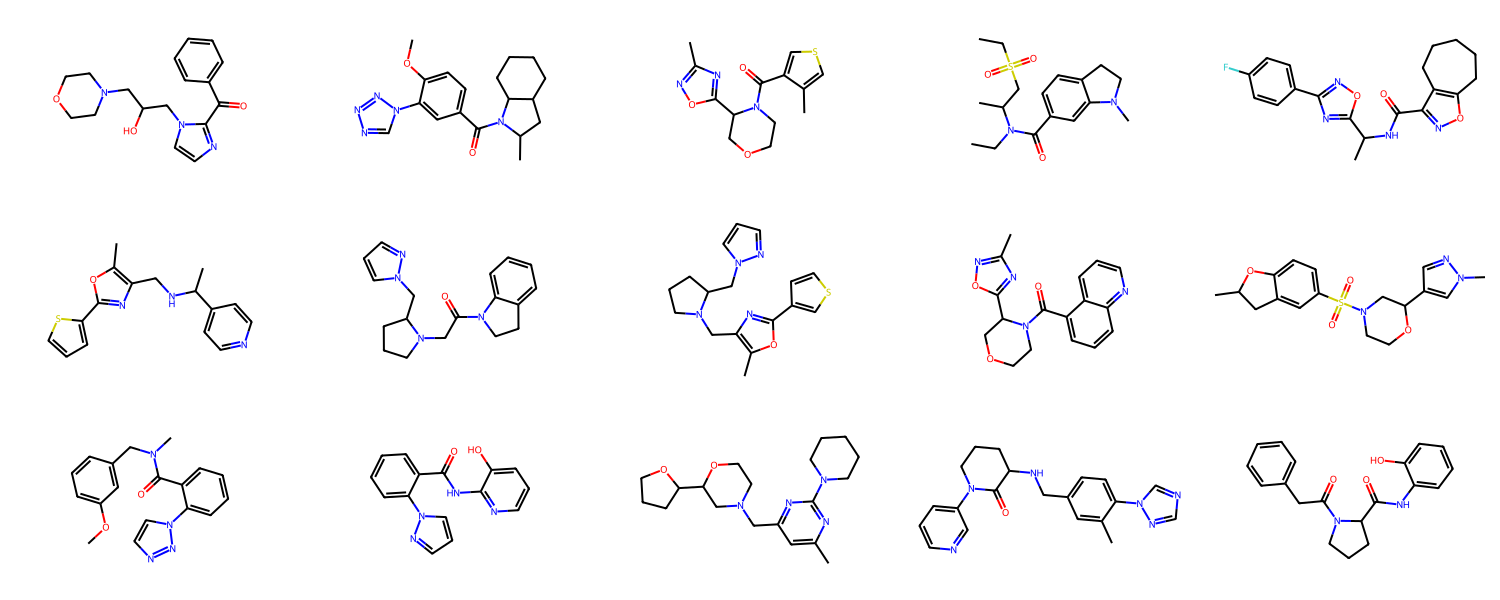

In [53]:
sample_smiles = pt_dataset['SMILES'].head(15)
molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]

# Visualize the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300, 200))
img

## Generating Descriptors & Morgan Fingerprints ##

The next step after we've loaded the dataset is to generate for each molecule `SMILE` value descriptors and morgan fingerprints in order to train our pre train model with `chemprop`.

We will extract the descriptors and morgan finger prints usin `RDKit` bioinformatics open source.

In [12]:
initial_descriptor_names = [
    "NumAtomStereoCenters",
    "NumAminoBonds",
    "MolWt",
    "NumValenceElectrons",
    "TPSA",
    "MolLogP",
    "NumHeteroatoms",
    "NumRotatableBonds",
    "HeavyAtomCount",
    "FractionCSP3",
    "NumAtomStereoCenters",
    "NumAminoBonds"
]

In [13]:
def generate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        initial_descriptors = [
            AllChem.CalcNumAtomStereoCenters(mol),
            AllChem.CalcNumAmideBonds(mol),
            Descriptors.MolWt(mol),
            Descriptors.NumValenceElectrons(mol),
            Descriptors.TPSA(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.FractionCSP3(mol)
        ]
        
        all_descriptors = []
        descriptor_names = []
        for name, func in Descriptors.descList:
            all_descriptors.append(func(mol))
            descriptor_names.append(name)
        
        # Compute Morgan fingerprints of size=100 and radius=2 in order to learn better representation of the molecules
        morgan_fp = GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
        morgan_fp_list = list(morgan_fp)
        morgan_fp_names = [f"MorganFP_{i}" for i in range(1024)]
        
        # Ensure we have at least 200 descriptors by padding if necessary
        if len(all_descriptors) < 200:
            all_descriptors.extend([None] * (200 - len(all_descriptors)))
            descriptor_names.extend([None] * (200 - len(descriptor_names)))
        
        # Replace the first 10 descriptors with the initial ones
        all_descriptors[:10] = initial_descriptors
        descriptor_names[:10] = initial_descriptor_names
        
        # Combine descriptors and Morgan fingerprints
        combined_descriptors = all_descriptors[:200] + morgan_fp_list
        combined_names = descriptor_names[:200] + morgan_fp_names
        
        return [smiles] + combined_descriptors, ["SMILES"] + combined_names
    else:
        return [smiles] + [None] * (200 + 1024), ["SMILES"] + [None] * (200 + 1024)

In [14]:
def generate_descriptors_df(df) -> pd.DataFrame:
    """
    Helper function that takes a list of molecule's SMILES values and generates a DataFrame
    with SMILES and 200 features, including specified descriptors.

    Params:
    - smiles_list (list of str): List of molecule's SMILES values as strings.

    Returns:
    - DataFrame: A DataFrame with the first column as SMILES and the other 200 columns as features.
    """
    data = []
    column_names = None
    for smiles in df['SMILES']:
        descriptors, names = generate_descriptors(smiles)
        data.append(descriptors)
        if column_names is None:
            column_names = names
    
    # Create DataFrame in the format of (SMILES, |<descriptors>| = 1224)
    df = pd.DataFrame(data, columns=column_names)
    
    return df

In [15]:
pt_dataset.head()

SMILES
0             O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1
1      COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1
2                Cc1noc(C2COCCN2C(=O)c2cscc2C)n1
3   CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC
4  CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1

### Generate Descriptors and Morgan Fingerprints ###

In [18]:
pt_dataset_final = generate_descriptors_df(pt_dataset)
PRINTM('Generated new data frame with descriptors and morgan fingerprints successfully !')

--------------------------------------------------------------------------------
Generated new data frame with descriptors and morgan fingerprints successfully !
--------------------------------------------------------------------------------


In [19]:
pt_dataset_final

SMILES  \
0                     O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1   
1              COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1   
2                        Cc1noc(C2COCCN2C(=O)c2cscc2C)n1   
3           CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC   
4          CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1   
...                                                  ...   
40635                    CC(C)(CNC(=N)N)N1CCc2ccccc2C1.I   
40636  Cc1ccc(C2=NN(C(=O)c3cccnc3)C(c3ccc(F)cc3)C2)cc...   
40637  CCOc1cccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CC2CC...   
40638                          CCn1cc(C2CSCCN2)cn1.Cl.Cl   
40639                         Cn1cc(C(N)=O)c(C2CCCNC2)n1   

       NumAtomStereoCenters  NumAminoBonds    MolWt  NumValenceElectrons  \
0                         1              0  315.373                  122   
1                         3              1  341.415                  132   
2                         1              1  293.348                  106   
3                         1              1  338.473                  128   
4                         1              1  370.384                  140   
...                     ...            ...      ...                  ...   
40635                     0              0  374.270                  106   
40636                     1              1  395.865                  142   
40637                     2              1  419.481                  160   
40638                     1              0  270.229                   88   
40639                     1              1  208.265                   82   

        TPSA  MolLogP  NumHeteroatoms  NumRotatableBonds  HeavyAtomCount  ...  \
0      67.59  0.80720               6                  6              23  ...   
1      73.14  2.46410               7                  3              25  ...   
2      68.46  1.96164               7                  2              20  ...   
3      57.69  1.96420               6                  6              23  ...   
4      94.05  3.62360               8                  4              27  ...   
...      ...      ...             ...                ...             ...  ...   
40635  65.14  1.92437               5                  3              19  ...   
40636  45.56  4.94242               6                  3              28  ...   
40637  87.68  3.90520               7                  6              31  ...   
40638  29.85  2.12410               6                  2              15  ...   
40639  72.94 -0.01400               5                  2              15  ...   

       MorganFP_1014  MorganFP_1015  MorganFP_1016  MorganFP_1017  \
0                  1              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
40635              0              0              0              0   
40636              0              0              0              0   
40637              0              0              0              0   
40638              0              0              0              0   
40639              0              0              0              0   

       MorganFP_1018  MorganFP_1019  MorganFP_1020  MorganFP_1021  \
0                  0              0              0              0   
1                  0              1              0              0   
2                  0              1              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
40635              0              0              0              0   
40636              0              1              0            

In [20]:
pt_dataset_final.to_csv(os.path.join('datasets', 'pt_dataset.csv'), index=False)
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [120]:
pt_dataset_final = pd.read_csv(os.path.join('datasets', 'pt_dataset.csv'))
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


### Handle Missing Values ###

The next step is verify whether there are any missing values (i.e., `Nan`) in the dataset. If there are any missing values, we will switch them with *0*. The reason for `Nan` value in some column for a givin SMILES can be the idea that the molecule doesnt have any recond for that descripton etc.

In [81]:
pt_dataset_final = pd.read_csv(os.path.join('datasets', 'pt_dataset.csv'))
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [83]:
rows_with_null = pt_dataset_final[pt_dataset_final.isnull().any(axis=1)]

PRINTM(f'There are -> {rows_with_null.shape[0]} rows that contains missing values in some of their column values (can be in more than one)')

--------------------------------------------------------------------------------
There are -> 1 rows that contains missing values in some of their column values (can be in more than one)
--------------------------------------------------------------------------------


In [84]:
def find_nan_columns(row):
    nan_columns = row[row.isna()].index.tolist()
    return nan_columns

In [85]:
pt_dataset_final['missing values columns'] = pt_dataset_final.apply(find_nan_columns, axis=1)
result_df = pt_dataset_final[pt_dataset_final['missing values columns'].apply(lambda x: len(x) > 0)]
result_df = result_df[['SMILES', 'missing values columns']]

PRINTM(f'The next data frame holds SMILES and their descriptor name that holds Nan values:')
result_df

--------------------------------------------------------------------------------
The next data frame holds SMILES and their descriptor name that holds Nan values:
--------------------------------------------------------------------------------


SMILES  \
31232  O=C([O-])Cc1csc(Cc2cccc(Cl)c2)n1.[Na+]   

                                  missing values columns  
31232  [FpDensityMorgan2, FpDensityMorgan3, BCUT2D_MW...

We can see that there is only one SMILES - `O=C([O-])Cc1csc(Cc2cccc(Cl)c2)n1.[Na+]` , that has columns of descriptors with missing values. After checking the other datasets, we've verified that this molecule is not present in them. Therefore, we will drop the row representing this SMILES because of the missing values. Since we have a large dataset (> 40,000), removing one row will not harm the pre-training process.

In [86]:
smiles_to_drop = 'O=C([O-])Cc1csc(Cc2cccc(Cl)c2)n1.[Na+]'
pt_dataset_final = pt_dataset_final[pt_dataset_final['SMILES'] != smiles_to_drop]
PRINTM(f'Dropped single row that represents the molecule SMILES:\nO=C([O-])Cc1csc(Cc2cccc(Cl)c2)n1.[Na+] successfully !')

--------------------------------------------------------------------------------
Dropped single row that represents the molecule SMILES:
O=C([O-])Cc1csc(Cc2cccc(Cl)c2)n1.[Na+] successfully !
--------------------------------------------------------------------------------


In [87]:
rows_with_null = pt_dataset_final[pt_dataset_final.isnull().any(axis=1)]
PRINTM(f'There are -> {rows_with_null.shape[0]} rows that contains missing values in some of their column values (can be in more than one)')

--------------------------------------------------------------------------------
There are -> 0 rows that contains missing values in some of their column values (can be in more than one)
--------------------------------------------------------------------------------


### Normalize the Data by Standart Scaler ###

In [90]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [95]:
smiles_column = 'SMILES'
descriptor_columns = pt_dataset_final.columns[1:201]
morgan_fp_columns = pt_dataset_final.columns[201:]  

In [96]:
smiles = pt_dataset_final[smiles_column].reset_index(drop=True)
descriptors = pt_dataset_final[descriptor_columns].reset_index(drop=True)
morgan_fps = pt_dataset_final[morgan_fp_columns].reset_index(drop=True)

scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(descriptors)
scaled_descriptors_df = pd.DataFrame(scaled_descriptors, columns=descriptor_columns)

# Combine the SMILES, scaled descriptors, and Morgan fingerprints back into a single df
scaled_pt_dataset_final = pd.concat([smiles, scaled_descriptors_df, morgan_fps], axis=1)

In [97]:
scaled_pt_dataset_final

SMILES  \
0                     O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1   
1              COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1   
2                        Cc1noc(C2COCCN2C(=O)c2cscc2C)n1   
3           CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC   
4          CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1   
...                                                  ...   
40634                    CC(C)(CNC(=N)N)N1CCc2ccccc2C1.I   
40635  Cc1ccc(C2=NN(C(=O)c3cccnc3)C(c3ccc(F)cc3)C2)cc...   
40636  CCOc1cccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CC2CC...   
40637                          CCn1cc(C2CSCCN2)cn1.Cl.Cl   
40638                         Cn1cc(C(N)=O)c(C2CCCNC2)n1   

       NumAtomStereoCenters  NumAminoBonds     MolWt  NumValenceElectrons  \
0                  0.275350      -1.282888 -0.845050            -0.596121   
1                  2.681269      -0.284300 -0.324994            -0.044691   
2                  0.275350      -0.284300 -1.284886            -1.478409   
3                  0.275350      -0.284300 -0.383746            -0.265263   
4                  0.275350      -0.284300  0.253513             0.396453   
...                     ...            ...       ...                  ...   
40634             -0.927610      -1.282888  0.331116            -1.478409   
40635              0.275350      -0.284300  0.762365             0.506739   
40636              1.478309      -0.284300  1.233974             1.499314   
40637              0.275350      -1.282888 -1.746570            -2.470983   
40638              0.275350      -0.284300 -2.983983            -2.801841   

           TPSA   MolLogP  NumHeteroatoms  NumRotatableBonds  HeavyAtomCount  \
0     -0.161588 -2.263520       -0.537124           1.030293       -0.672638   
1      0.165290 -0.451371        0.148930          -0.852016       -0.099342   
2     -0.110347 -1.000911        0.148930          -1.479452       -1.532583   
3     -0.744666 -0.998111       -0.537124           1.030293       -0.672638   
4      1.396822  0.816772        0.834984          -0.224580        0.473955   
...         ...       ...             ...                ...             ...   
40634 -0.305885 -1.041673       -1.223178          -0.852016       -1.819231   
40635 -1.459084  2.259163       -0.537124          -0.852016        0.760603   
40636  1.021650  1.124757        0.148930           1.030293        1.620548   
40637 -2.384354 -0.823228       -0.537124          -1.479452       -2.965824   
40638  0.153510 -3.161664       -1.223178          -1.479452       -2.965824   

       ...  MorganFP_1015  MorganFP_1016  MorganFP_1017  MorganFP_1018  \
0      ...              0              0              0              0   
1      ...              0              0              0              0   
2      ...              0              0              0              0   
3      ...              0              0              0              0   
4      ...              0              0              0              0   
...    ...            ...            ...            ...            ...   
40634  ...              0              0              0              0   
40635  ...              0              0              0              0   
40636  ...              0              0              0              0   
40637  ...              0              0              0              0   
40638  ...              0              0              0              0   

       MorganFP_1019  MorganFP_1020  MorganFP_1021  MorganFP_1022  \
0                  0              0              0              0   
1                  1              0              0              0   
2                  1              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
40634              0              0              0              0   
40

In [113]:
scaled_pt_dataset_final.drop(columns=['missing values columns'], inplace=True)
PRINT()

--------------------------------------------------------------------------------
Done
--------------------------------------------------------------------------------


In [115]:
PRINTM(f'First 50 descriptors of the dataset:\n\n{scaled_pt_dataset_final.columns.tolist()[:50]}')

--------------------------------------------------------------------------------
First 50 descriptors of the dataset:

['SMILES', 'NumAtomStereoCenters', 'NumAminoBonds', 'MolWt', 'NumValenceElectrons', 'TPSA', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'HeavyAtomCount', 'FractionCSP3', 'NumAtomStereoCenters.1', 'NumAminoBonds.1', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA']
--------------------------------------------------------------------------------


In [116]:
scaled_pt_dataset_final.to_csv(os.path.join('datasets', 'pt_dataset_final_scaled.csv'), index=False)
PRINTM('Saved')

--------------------------------------------------------------------------------
Saved
--------------------------------------------------------------------------------


In [117]:
scaled_pt_dataset_final

SMILES  \
0                     O=C(c1ccccc1)c1nccn1CC(O)CN1CCOCC1   
1              COc1ccc(C(=O)N2C(C)CC3CCCCC32)cc1-n1cnnn1   
2                        Cc1noc(C2COCCN2C(=O)c2cscc2C)n1   
3           CCN(C(=O)c1ccc2c(c1)N(C)CC2)C(C)CS(=O)(=O)CC   
4          CC(NC(=O)c1noc2c1CCCCC2)c1nc(-c2ccc(F)cc2)no1   
...                                                  ...   
40634                    CC(C)(CNC(=N)N)N1CCc2ccccc2C1.I   
40635  Cc1ccc(C2=NN(C(=O)c3cccnc3)C(c3ccc(F)cc3)C2)cc...   
40636  CCOc1cccc(C2c3c(-c4ccccc4O)n[nH]c3C(=O)N2CC2CC...   
40637                          CCn1cc(C2CSCCN2)cn1.Cl.Cl   
40638                         Cn1cc(C(N)=O)c(C2CCCNC2)n1   

       NumAtomStereoCenters  NumAminoBonds     MolWt  NumValenceElectrons  \
0                  0.275350      -1.282888 -0.845050            -0.596121   
1                  2.681269      -0.284300 -0.324994            -0.044691   
2                  0.275350      -0.284300 -1.284886            -1.478409   
3                  0.275350      -0.284300 -0.383746            -0.265263   
4                  0.275350      -0.284300  0.253513             0.396453   
...                     ...            ...       ...                  ...   
40634             -0.927610      -1.282888  0.331116            -1.478409   
40635              0.275350      -0.284300  0.762365             0.506739   
40636              1.478309      -0.284300  1.233974             1.499314   
40637              0.275350      -1.282888 -1.746570            -2.470983   
40638              0.275350      -0.284300 -2.983983            -2.801841   

           TPSA   MolLogP  NumHeteroatoms  NumRotatableBonds  HeavyAtomCount  \
0     -0.161588 -2.263520       -0.537124           1.030293       -0.672638   
1      0.165290 -0.451371        0.148930          -0.852016       -0.099342   
2     -0.110347 -1.000911        0.148930          -1.479452       -1.532583   
3     -0.744666 -0.998111       -0.537124           1.030293       -0.672638   
4      1.396822  0.816772        0.834984          -0.224580        0.473955   
...         ...       ...             ...                ...             ...   
40634 -0.305885 -1.041673       -1.223178          -0.852016       -1.819231   
40635 -1.459084  2.259163       -0.537124          -0.852016        0.760603   
40636  1.021650  1.124757        0.148930           1.030293        1.620548   
40637 -2.384354 -0.823228       -0.537124          -1.479452       -2.965824   
40638  0.153510 -3.161664       -1.223178          -1.479452       -2.965824   

       ...  MorganFP_1014  MorganFP_1015  MorganFP_1016  MorganFP_1017  \
0      ...              1              0              0              0   
1      ...              0              0              0              0   
2      ...              0              0              0              0   
3      ...              0              0              0              0   
4      ...              0              0              0              0   
...    ...            ...            ...            ...            ...   
40634  ...              0              0              0              0   
40635  ...              0              0              0              0   
40636  ...              0              0              0              0   
40637  ...              0              0              0              0   
40638  ...              0              0              0              0   

       MorganFP_1018  MorganFP_1019  MorganFP_1020  MorganFP_1021  \
0                  0              0              0              0   
1                  0              1              0              0   
2                  0              1              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
40634              0              0              0              0   
40